# Analysis of LN18, GBM43, GL261, SB28 and T98G RT screens
This notebook assumes the existence of top-level `data/` and `output` directories. Please see the attached `environment.yml` file in order to reproduce the environment used for this analysis. Note that here, we're starting from existing count data and generating screen data and plots.

Note that we used cutoffs of 7 in here.

## Imports and setup

In [1]:
import os
import math

import numpy as np
import pandas as pd
import anndata as ad
from screenpro.assays import PooledScreens
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from adjustText import adjust_text
from scipy.stats import pearsonr

pd.options.mode.copy_on_write = True
matplotlib.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.family'] = 'Helvetica'


In [2]:
CELL_LINE = "LN18"
TREATMENT = "RT"
DATA_DIR = f"../data/{CELL_LINE}_screen"
OUTPUT_DIR = f"../output/invitro_screen_outputs/{CELL_LINE}"

In [3]:
counts = pd.read_csv(os.path.join(DATA_DIR, f"{CELL_LINE}_zim3_merged_counts.txt"), sep = "\t").set_index("guide")
counts.head(5)

,target,LN18_UMI_C1,LN18_UMI_C2,LN18_UMI_C3,LN18_UMI_RT1,LN18_UMI_RT2,LN18_UMI_RT3,LN18_UMI_T0_1,LN18_UMI_T0_2,LN18_UMI_T0_3,LN18_UMI_T1,LN18_UMI_T2,LN18_UMI_T3,LN18_UMI_V1,LN18_UMI_V2,LN18_UMI_V3
guide,,,,,,,,,,,,,,,,
A1BG_-_58864840.23-P2|A1BG_-_58864822.23-P2,A1BG,2459,3197,2243,3027,2154,3841,2008,744,323,1080,774,3430,2208,1909,3115
A1BG_+_58858964.23-P1|A1BG_-_58858788.23-P1,A1BG,4376,3683,4165,7040,6095,3744,3588,1400,580,4254,586,326,3185,3311,2314
A1CF_+_52645339.23-P1P2|A1CF_-_52645373.23-P1P2,A1CF,1860,1612,1346,2162,964,1077,1984,657,231,1248,43,3361,1751,1401,1408
A2M_+_9268487.23-P1P2|A2M_+_9268495.23-P1P2,A2M,2667,3142,4257,4201,2206,1595,1999,920,500,14613,2408,4934,2409,4259,2431
A2ML1_+_8975211.23-P1P2|A2ML1_-_8975593.23-P1P2,A2ML1,2873,2918,2645,2510,1976,1950,1496,532,374,5005,1216,1098,2197,2477,3096


In [4]:
samplesheet = pd.read_csv(os.path.join(DATA_DIR, "samplesheet.txt")).set_index("Index")
samplesheet = samplesheet[samplesheet['Treat'].isin(['T0', 'RT', 'DMSO'])]
samplesheet

,Treat,Rep,Doubling
Index,,,
LN18_UMI_T0_1,T0,1,NaN
LN18_UMI_T0_2,T0,2,NaN
LN18_UMI_T0_3,T0,3,NaN
LN18_UMI_V1,DMSO,1,9.132521
LN18_UMI_V2,DMSO,2,9.154621
LN18_UMI_V3,DMSO,3,13.103396
LN18_UMI_RT1,RT,1,7.601162
LN18_UMI_RT2,RT,2,7.470046
LN18_UMI_RT3,RT,3,7.088979


In [5]:
# For each replicate, generate all of the following:
def process_replicate(replicates, counts, samplesheet, normalize_by_doubling=True):
    """
    Note for best results, make sure that counts is indexed by guide, not by gene.
    """
    print(f"Processing replicates: {replicates}")

    replicate_samplesheet = samplesheet[samplesheet['Rep'].isin(replicates)]
    
    # Create an AnnData object for the current replicate
    counts_replicate = counts.loc[:, replicate_samplesheet.index]
    adata_replicate = ad.AnnData(X=counts_replicate.T, obs=replicate_samplesheet)
    
    # Make a PooledScreens object from the adata object
    screen_replicate = PooledScreens(adata_replicate, n_reps=len(replicates))
    
    # Prepare the pooled screens object so it has everything we need to operate on it
    screen_replicate.adata.var['targetType'] = ['negative_control' if 'non-targeting' in target else 'gene' for target in adata_replicate.var_names]
    
    # "condition" column required by calculateDrugScreen
    screen_replicate.adata.obs['condition'] = screen_replicate.adata.obs['Treat']
    
    # "replicate" column required by _calculateGrowthFactor
    screen_replicate.adata.obs['replicate'] = screen_replicate.adata.obs['Rep']
    
    # "pop_doubling" column required by _getTreatmentDoublingRate
    screen_replicate.adata.obs['pop_doubling'] = screen_replicate.adata.obs['Doubling']
    
    # "target" column required
    screen_replicate.adata.var['target'] = adata_replicate.var.index
    screen_replicate.verbose = True
    
    # Filter guides based on average count of T0 replicates
    def filter_guides_by_t0_average(adata, threshold=50):
        print(f"Eliminating bad T0 guides with threshold {threshold}")
        initial_genes = adata.shape[1]
        t0_replicates = adata.obs[adata.obs['condition'] == 'T0'].index
        t0_counts = adata[adata.obs.index.isin(t0_replicates),:].X
        avg_t0_counts = np.mean(t0_counts, axis=0)
        guides_to_keep = avg_t0_counts >= threshold
        adata = adata[:, guides_to_keep].copy()
        print(f"Eliminated {initial_genes - adata.shape[1]} bad guides...")
        return adata
    screen_replicate.adata = filter_guides_by_t0_average(screen_replicate.adata)
    
    # Add pseudocounts and normalize to the total number of counts again
    screen_replicate.countNormalization(pseudo_count_value=0.5)

    # Check if there are any items in screen_replicate.adata.X that are == 0 or less than 0
    zero_or_negative_values = (screen_replicate.adata.X <= 0).sum()
    print(f"Number of zero or negative values in screen_replicate.adata.X: {zero_or_negative_values}")
    
    # Calculate phenotype scores using the replicates as means of comparison. Include the number of
    # doublings as specified in the samplesheet. Note that this column 
    # import pdb; pdb.set_trace()
    screen_replicate.calculateDrugScreen(
        score_level="compare_reps",
        untreated="DMSO",
        treated=TREATMENT,
        t0="T0",
        db_rate_col="pop_doubling" if normalize_by_doubling else None,
        run_name=f"Run for {replicates}",
        count_filter_threshold=0
    )
    screen_replicate.test = 'ttest'
    print("Done calculating replicates")

    # Get each of the score sets and drop any NaN values
    gamma_scores = screen_replicate.phenotypes[f"Run for {replicates}"]['results']['gamma:DMSO_vs_T0'].dropna()
    rho_scores = screen_replicate.phenotypes[f"Run for {replicates}"]['results'][f'rho:{TREATMENT}_vs_DMSO'].dropna()
    tau_scores = screen_replicate.phenotypes[f"Run for {replicates}"]['results'][f'tau:{TREATMENT}_vs_T0'].dropna()
    
    return gamma_scores, rho_scores, tau_scores

## Volcano plot analysis

In [6]:
# Run for all 3 replicates at the same time
replicates = samplesheet['Rep'].unique().tolist()
gamma_scores, rho_scores, tau_scores = process_replicate(replicates, counts, samplesheet)

Processing replicates: [1, 2, 3]
Eliminating bad T0 guides with threshold 50
Eliminated 55 bad guides...
Pseudocount added to counts.
Counts normalized by sequencing depth.
Number of zero or negative values in screen_replicate.adata.X: 0
	DMSO vs T0
	RT vs T0
	RT vs DMSO
Done calculating replicates


In [7]:
# Run for all 3 replicates at the same time, but do not normalize by doubling
gamma_scores_raw, rho_scores_raw, tau_scores_raw = process_replicate(replicates, counts, samplesheet, normalize_by_doubling=False)

Processing replicates: [1, 2, 3]
Eliminating bad T0 guides with threshold 50
Eliminated 55 bad guides...
Pseudocount added to counts.
Counts normalized by sequencing depth.
Number of zero or negative values in screen_replicate.adata.X: 0
	DMSO vs T0


/opt/miniconda3/envs/human_gbm_dnapk/lib/python3.11/site-packages/screenpro/assays/__init__.py:85: UserWarning: No doubling rate information provided.
  warnings.warn('No doubling rate information provided.')
/opt/miniconda3/envs/human_gbm_dnapk/lib/python3.11/site-packages/screenpro/assays/__init__.py:85: UserWarning: No doubling rate information provided.
  warnings.warn('No doubling rate information provided.')


	RT vs T0
	RT vs DMSO
Done calculating replicates


In [8]:
# Unify the gamma scores, rho scores, and tau scores based on their normalized and unnormalized values and add gene values
gamma_scores = gamma_scores.join(gamma_scores_raw, lsuffix='', rsuffix='_raw')
rho_scores = rho_scores.join(rho_scores_raw, lsuffix='', rsuffix='_raw')
tau_scores = tau_scores.join(tau_scores_raw, lsuffix='', rsuffix='_raw')

In [9]:
# Add in the gene target names from the counts matrix
gamma_scores['target'] = counts['target'].loc[gamma_scores.index]
rho_scores['target'] = counts['target'].loc[rho_scores.index]
tau_scores['target'] = counts['target'].loc[tau_scores.index]
gamma_scores.head(5)

,target,score,ttest pvalue,BH adj_pvalue,target_raw,score_raw,ttest pvalue_raw,BH adj_pvalue_raw
guide,,,,,,,,
A1BG_-_58864840.23-P2|A1BG_-_58864822.23-P2,A1BG,0.007721,0.524907,0.715150,A1BG_-_58864840.23-P2|A1BG_-_58864822.23-P2,0.080792,0.524907,0.715150
A1BG_+_58858964.23-P1|A1BG_-_58858788.23-P1,A1BG,-0.046430,0.065290,0.252943,A1BG_+_58858964.23-P1|A1BG_-_58858788.23-P1,-0.485819,0.065290,0.252943
A1CF_+_52645339.23-P1P2|A1CF_-_52645373.23-P1P2,A1CF,-0.031976,0.584035,0.757324,A1CF_+_52645339.23-P1P2|A1CF_-_52645373.23-P1P2,-0.334578,0.584035,0.757324
A2M_+_9268487.23-P1P2|A2M_+_9268495.23-P1P2,A2M,0.007577,0.292740,0.525763,A2M_+_9268487.23-P1P2|A2M_+_9268495.23-P1P2,0.079280,0.292740,0.525763
A2ML1_+_8975211.23-P1P2|A2ML1_-_8975593.23-P1P2,A2ML1,0.041386,0.003549,0.103718,A2ML1_+_8975211.23-P1P2|A2ML1_-_8975593.23-P1P2,0.433047,0.003549,0.103718


In [10]:
# Calculate combined scores for each of the guides
for df in [gamma_scores, rho_scores, tau_scores]:
    target_condition = df['target'].eq('non-targeting')
    filtered_df = df.loc[target_condition]
    pseudo_sd_list = filtered_df['score'].tolist()
    pseudo_sd = np.std(pseudo_sd_list)
    df['combined_score'] = df['score'] / pseudo_sd * -np.log10(df['ttest pvalue'])
    df['log_pvalue'] = -np.log10(df['ttest pvalue'])
    df['absolute_combined_score'] = abs(df['combined_score'])

In [22]:
# Find an absolute score threshold such that the score makes it so that the top 2% of NTC phenotypes make it into the hits
def find_threshold(df):
    # Find the number of non-targeting guides
    number_nt_guides = df[df['target'] == 'non-targeting'].shape[0]
    number_one_percent_guides = math.ceil(0.02 * number_nt_guides) # Optimized to 2300 gamma hits

    # Find the combined score threshold that will include this number of NTC guides
    df_sorted = df.sort_values('absolute_combined_score', ascending=False)
    df_sorted['cumulative_nt'] = df_sorted['target'].eq('non-targeting').cumsum()
    threshold = df_sorted[df_sorted['cumulative_nt'] == number_one_percent_guides].iloc[-1]['absolute_combined_score']
    return threshold

# Or use the empirical threshold of 7
gamma_threshold, rho_threshold, tau_threshold = 7, 7, 7

In [24]:
# Label as hits vs. not hits based on absolute combined score vs. the threshold.
def label_hits(df, threshold):
    df['is_hit'] = df['absolute_combined_score'] > threshold

label_hits(gamma_scores, gamma_threshold)
label_hits(rho_scores, rho_threshold)
label_hits(tau_scores, tau_threshold)

In [25]:
# Join all the dataframes together, being permissive with join
# Join gamma_scores, rho_scores, and tau_scores together by index
combined_scores = gamma_scores.add_suffix('_gamma').join(
    rho_scores.add_suffix('_rho'), how='outer'
).join(
    tau_scores.add_suffix('_tau'), how='outer'
)

# Download the combined dataframe as a CSV file
combined_scores.to_csv(os.path.join(OUTPUT_DIR, 'combined_scores.csv'))


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


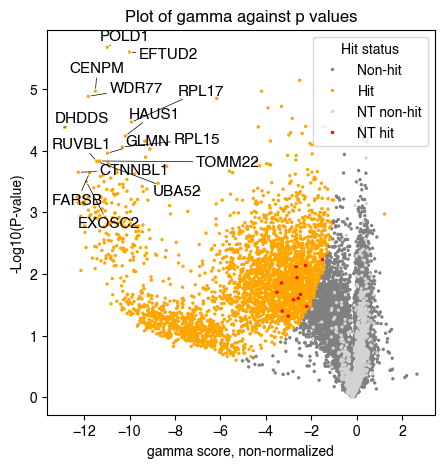

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


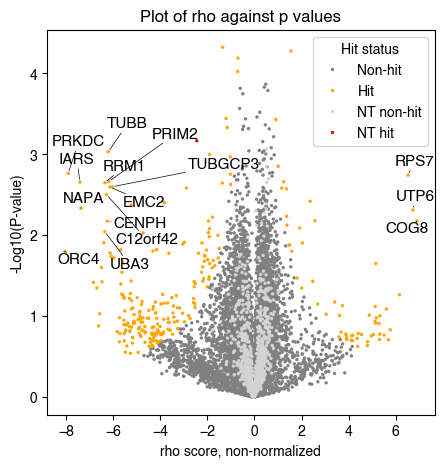

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


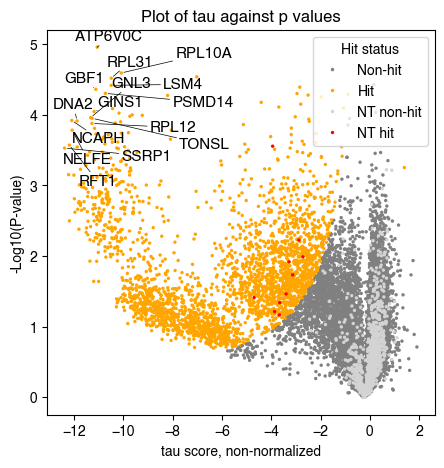

In [26]:
# Display hits, scores, and p-values on a volcano plot

def make_volcano_plot(df, label, threshold, plot_lims=None):
    # Determine the color based on the non-targeting/hit status
    def determine_color(row):
        if row['is_hit'] and row['target'] == 'non-targeting':
            return 'NT hit'
        elif row['is_hit'] and row['target'] != 'non-targeting':
            return 'Hit'
        elif not row['is_hit'] and row['target'] == 'non-targeting':
            return 'NT non-hit'
        else:
            return 'Non-hit'
    df['Hit status'] = df.apply(determine_color, axis = 1)
    palette = {
        "NT hit": "red",
        "Hit": "orange",
        "NT non-hit": "lightgray",
        "Non-hit": "gray"
    }

    plt.figure(figsize=(5, 5))
    # Plot the targeting data first
    sns.scatterplot(
        x='score_raw',
        y='log_pvalue',
        data=df[df["target"] != 'non-targeting'],
        hue=df['Hit status'],
        palette=palette,
        legend=False,
        s=6,
        edgecolor='none'
    )

    sns.scatterplot(
        x='score_raw',
        y='log_pvalue',
        data=df[df["target"] == 'non-targeting'],
        hue=df['Hit status'],
        palette=palette,
        legend=True,
        s=6,
        edgecolor='none'
    )
    # Threshold if need
    if plot_lims:
        plt.xlim(plot_lims[0], plot_lims[1])  # Adjust x-axis limits

    top_genes = df.nlargest(15, 'absolute_combined_score')
    genes_of_interest = df[df['target'].isin(['Rbx1', 'Sfpq', 'Prkdc'])]
    to_plot = pd.concat([top_genes, genes_of_interest]).drop_duplicates()
    texts = []
    for _, row in to_plot.iterrows():
        if row['target'] != 'non-targeting':
            text = plt.text(row['score_raw'], row['log_pvalue'], row['target'], fontsize=11)
            texts.append(text)

    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='black', lw=0.5), force_text=(0.25, 0.8), min_arrow_len=0)
    plt.xlabel(f'{label} score, non-normalized')
    plt.ylabel('-Log10(P-value)')
    plt.title(f'Plot of {label} against p values')
    plt.savefig(os.path.join(OUTPUT_DIR, f"{CELL_LINE}_{label}_hits_volcano_plot.pdf"))
    plt.show()

make_volcano_plot(gamma_scores, "gamma", gamma_threshold)
make_volcano_plot(rho_scores, "rho", rho_threshold)
make_volcano_plot(tau_scores, "tau", tau_threshold)

## Interreplicate reproducibility

For replicate reproducibility, we need to index by guide. This is because later, when comparing replicate phenotype scores to each other, we can't just rely on genes; we have to rely on guides.

In [ ]:
replicates = samplesheet['Rep'].unique()
results_dict = {}
for replicate in replicates:
    gamma_scores, rho_scores, tau_scores = process_replicate([replicate], counts, samplesheet)
    gamma_scores_raw, rho_scores_raw, tau_scores_raw = process_replicate([replicate], counts, samplesheet, normalize_by_doubling=False)

    gamma_scores = gamma_scores.join(gamma_scores_raw, lsuffix='', rsuffix='_raw')
    rho_scores = rho_scores.join(rho_scores_raw, lsuffix='', rsuffix='_raw')
    tau_scores = tau_scores.join(tau_scores_raw, lsuffix='', rsuffix='_raw')

    gamma_scores['target'] = counts['target'].loc[gamma_scores.index]
    rho_scores['target'] = counts['target'].loc[rho_scores.index]
    tau_scores['target'] = counts['target'].loc[tau_scores.index]

    results_dict[replicate] = {}
    results_dict[replicate]['gamma'] = gamma_scores
    results_dict[replicate]['rho'] = rho_scores
    results_dict[replicate]['tau'] = tau_scores

In [ ]:
score_types = ['gamma', 'rho', 'tau']
replicates = list(results_dict.keys())
replicate_pairs = [(1, 2), (2, 3), (1, 3)]

# Create a huge merged dataframe with all replicate pairs' scores
merged_dfs = {}
for score_type in score_types:
    merged_dfs[score_type] = {}
    for replicate_pair in replicate_pairs:
        replicate1, replicate2 = replicate_pair
        df1 = results_dict[replicate1][score_type]
        df2 = results_dict[replicate2][score_type]
        merged_df = df1.merge(df2, left_index=True, right_index=True, suffixes=(f'_{replicate1}', f'_{replicate2}'))
        merged_df['nt_status'] = merged_df.index.to_series().apply(lambda x: 'non-targeting' if 'non-targeting' in x else 'targeting')
        merged_dfs[score_type][replicate_pair] = merged_df

In [ ]:
# Create a scatterplot for each replicate comparison
colors = {'non-targeting': 'lightgray', 'targeting': 'black'}

# Plotting using the precomputed merged dataframes
for score_type in score_types:
    fig.suptitle(f'Scatterplots for {score_type} scores across replicates')
    ax_counter = 0
    for replicate_pair in replicate_pairs:
        fig, ax = plt.subplots(figsize=(5, 5))
        merged_df = merged_dfs[score_type][replicate_pair]
        replicate1, replicate2 = replicate_pair
        # Plot the targeting data first
        sns.scatterplot(
            x=f'score_raw_{replicate1}', y=f'score_raw_{replicate2}', 
            hue='nt_status', 
            data=merged_df[merged_df['nt_status'] == 'targeting'], 
            ax=ax, 
            palette=colors, 
            legend=False, 
            alpha=1,
            edgecolor='none',
            s=6
        )
        
        # Plot the non-targeting data on top
        sns.scatterplot(
            x=f'score_raw_{replicate1}', y=f'score_raw_{replicate2}', 
            hue='nt_status', 
            data=merged_df[merged_df['nt_status'] == 'non-targeting'], 
            ax=ax, 
            palette=colors, 
            legend=False, 
            alpha=1,
            edgecolor='none',
            s=6
        )

        ax.axhline(y=0, color='gray', linestyle='--')
        ax.axvline(x=0, color='gray', linestyle='--')
        ax.axline(xy1=(0, 0), slope=1, color='gray', linestyle='--')

        ax.set_xlim(-12.5, 7.5)
        ax.set_ylim(-12.5, 7.5)

        corr, _ = pearsonr(merged_df[f'score_{replicate1}'], merged_df[f'score_{replicate2}'])
        ax.set_title(f'Replicate {replicate1} vs {replicate2}\nPearson r: {corr:.2f}')
        ax.set_xlabel(f'{score_type} score {replicate1}')
        ax.set_ylabel(f'{score_type} score {replicate2}')
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, f"{CELL_LINE}_{score_type}_interreplicate_scatterplot_{replicate1}_vs_{replicate2}.pdf"))
        plt.show()
        ax_counter += 1


## Unifying dataframes

In [ ]:
# Read in both the T98G and LN18 dataframes
ln18_df = pd.read_csv('../output/LN18_screen/combined_scores.csv', index_col=0)
t98g_df = pd.read_csv('../output/T98G_screen/combined_scores.csv', index_col=0)

# Combine them by their indices
combined_df = t98g_df.join(ln18_df, lsuffix='_T98G', rsuffix='_LN18', how = 'outer')
combined_df.to_csv("../output/table_s3.csv")

## Plotting only

In [222]:
# Import the GL261_1+2 phenotype scores, which have been modified by adding non-targeting labels and raw scores
phenotype_scores = pd.read_csv(os.path.join(DATA_DIR, f"SB28_RT_count_results.txt"), sep = "\t")
phenotype_scores

,Unnamed: 0,gene,gamma.mwp,gamma.score,rho.mwp,rho.score,tau.mwp,tau.score
0,0,0610007P14Rik,0.338619,-0.013788,0.435571,-0.056319,0.840587,-0.019702
1,1,0610009B22Rik,0.056387,-0.072122,0.231937,0.120781,0.958816,-0.073864
2,2,0610009D07Rik,0.104360,-0.204077,0.337036,-0.078077,0.004624,-0.288099
3,3,0610009O20Rik,0.826051,0.009705,0.385115,-0.017493,0.771281,-0.035499
4,4,0610010F05Rik,0.923652,-0.002746,0.711512,0.033210,0.630254,0.008960
...,...,...,...,...,...,...,...,...
40001,40001,pseudo_9995,0.159035,-0.040829,0.074664,0.118960,0.651703,-0.011192
40002,40002,pseudo_9996,0.052984,0.042181,0.155192,-0.079888,0.266655,0.031805
40003,40003,pseudo_9997,0.547638,-0.018263,0.831373,-0.007841,0.897707,-0.044755
40004,40004,pseudo_9998,0.592143,0.005471,0.924889,-0.008066,0.781520,-0.001683


In [223]:
# Split into different phenotype plots called gamma_scores, rho_scores, and tau_scores. Note that the thresholds
# represent absolute value combined scores.
def calculate_scores(df, score_type, averages):
    scores = df[['gene', f'{score_type}.mwp', f'{score_type}.score']].copy()
    scores['score_raw'] = scores[f'{score_type}.score'] * np.mean(averages)  # Adjust mean values as needed for tau and rho
    scores['target'] = scores['gene']
    target_condition = scores['target'].str.contains('pseudo')
    filtered_df = scores.loc[target_condition]
    pseudo_sd_list = filtered_df[f'{score_type}.score'].tolist()
    pseudo_sd = np.std(pseudo_sd_list)
    scores['combined_score'] = scores[f'{score_type}.score'] / pseudo_sd * -np.log10(scores[f'{score_type}.mwp'])
    scores['log_pvalue'] = -np.log10(scores[f'{score_type}.mwp'])
    scores['absolute_combined_score'] = abs(scores['combined_score'])
    scores.loc[target_condition, 'target'] = 'non-targeting'
    return scores

gamma_scores = calculate_scores(phenotype_scores, 'gamma', [10.71265884, 10.6012433])
rho_scores = calculate_scores(phenotype_scores, 'rho', [7.140599703, 6.785286585])
tau_scores = calculate_scores(phenotype_scores, 'tau', [7.140599703, 6.785286585])

In [206]:
# Calculate a column that represents the running FDR rate if the cutoff were drawn at that point
# def calculate_running_fdr_column(df):
#     df_sorted = df.sort_values('absolute_combined_score', ascending=False)
#     df_sorted['cumulative_nt'] = df_sorted['target'].eq('non-targeting').cumsum()
#     df_sorted['cumulative_non_nt'] = df_sorted['target'].ne('non-targeting').cumsum()
#     df_sorted['FDR_rate'] = df_sorted['cumulative_nt'] / (df_sorted['cumulative_non_nt'] + df_sorted['cumulative_nt'])
#     return df_sorted

# df = calculate_running_fdr_column(rho_scores)
# df['row_order'] = range(len(df))
# df['abs_diff'] = (df['FDR_rate'] - 0.02).abs()
# closest_rows = df.sort_values(by='abs_diff').head(50)
# closest_rows
# gene_hits = df['target'].ne('non-targeting')
# positive_scores = df[df['score'] > 0].shape[0]
# negative_scores = df[df['score'] < 0].shape[0]
# positive_scores, negative_scores

# plt.plot(df['row_order'], df['FDR_rate'])

# # Optionally set labels and title
# plt.xlabel('Index')
# plt.ylabel('Y values')
# plt.title('Line Plot of FDR')

# # Display the plot
# plt.show()

# plt.plot(df['row_order'], df['cumulative_non_nt'])

# # Optionally set labels and title
# plt.xlabel('Index')
# plt.ylabel('Y values')
# plt.title('Line Plot of hits')

# # Display the plot
# plt.show()

# df['target_type'] = df['target'].apply(lambda x: 'non-targeting' if x == 'non-targeting' else 'non-non-targeting')

# # Plot using seaborn for easy comparison (boxplot or scatter plot)
# plt.figure(figsize=(10, 6))

# # Using boxplot to compare the distributions
# sns.boxplot(x='target_type', y='absolute_combined_score', data=df)

# # Optionally set labels and title
# plt.xlabel('Target Type')
# plt.ylabel('Absolute Combined Score')
# plt.title('Comparison of Absolute Combined Scores: Non-targeting vs Non-non-targeting')

# # Display the plot
# plt.show()



In [207]:
# non_targeting = df[df['target'] == 'non-targeting']
# targeting = df[df['target'] != 'non-targeting']

# # Calculate summary statistics for non-targeting guides
# summary_non_targeting = non_targeting['absolute_combined_score'].describe()

# # Calculate summary statistics for targeting guides
# summary_targeting = targeting['absolute_combined_score'].describe()

# # Display the summary statistics
# print("Summary statistics for non-targeting guides:")
# print(summary_non_targeting)

# print("\nSummary statistics for targeting guides:")
# print(summary_targeting)

In [225]:
# Find an absolute score threshold such that the score makes it so that the top 2% of NTC phenotypes make it into the hits
# def find_threshold(df):
#     # Find the number of non-targeting guides
#     number_nt_guides = df[df['target'] == 'non-targeting'].shape[0]
#     number_guides = df.shape[0]
#     number_one_percent_guides = math.ceil(0.01 * number_nt_guides) # Optimized to 2300 gamma hits

#     # Find the combined score threshold that will include this number of NTC guides
#     df_sorted = df.sort_values('absolute_combined_score', ascending=False)
#     df_sorted['cumulative_nt'] = df_sorted['target'].eq('non-targeting').cumsum()
#     threshold = df_sorted[df_sorted['cumulative_nt'] == number_one_percent_guides].iloc[-1]['absolute_combined_score']
#     return threshold

# gamma_threshold = find_threshold(gamma_scores)
# rho_threshold = find_threshold(rho_scores)
# tau_threshold = find_threshold(tau_scores)

gamma_threshold = 7
rho_threshold = 7
tau_threshold = 7

In [226]:
# Label as hits vs. not hits based on absolute combined score vs. the threshold.
def label_hits(df, threshold):
    df['is_hit'] = df['absolute_combined_score'] > threshold

label_hits(gamma_scores, gamma_threshold)
label_hits(rho_scores, rho_threshold)
label_hits(tau_scores, tau_threshold)

In [227]:
# Join all the dataframes together, being permissive with join
# Join gamma_scores, rho_scores, and tau_scores together by index
gamma_scores.set_index('gene')
tau_scores.set_index('gene')
rho_scores.set_index('gene')

combined_scores = gamma_scores.add_suffix('_gamma').join(
    rho_scores.add_suffix('_rho'), how='outer'
).join(
    tau_scores.add_suffix('_tau'), how='outer'
)

# Download the combined dataframe as a CSV file
combined_scores.to_csv(os.path.join(OUTPUT_DIR, 'combined_scores.csv'))

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


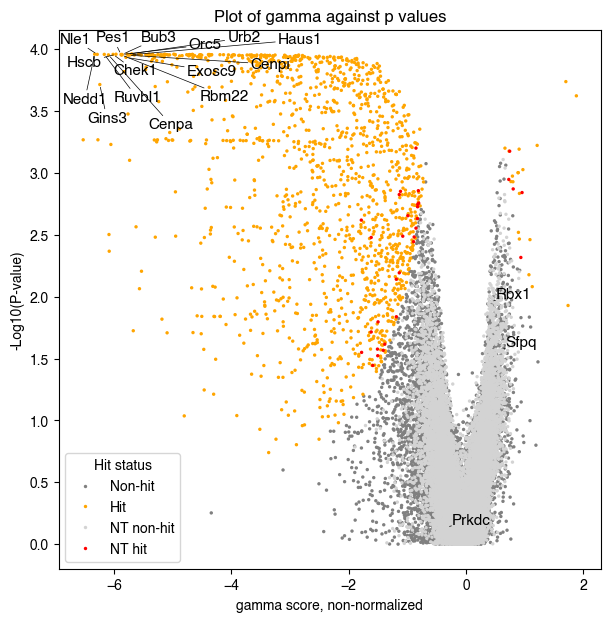

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


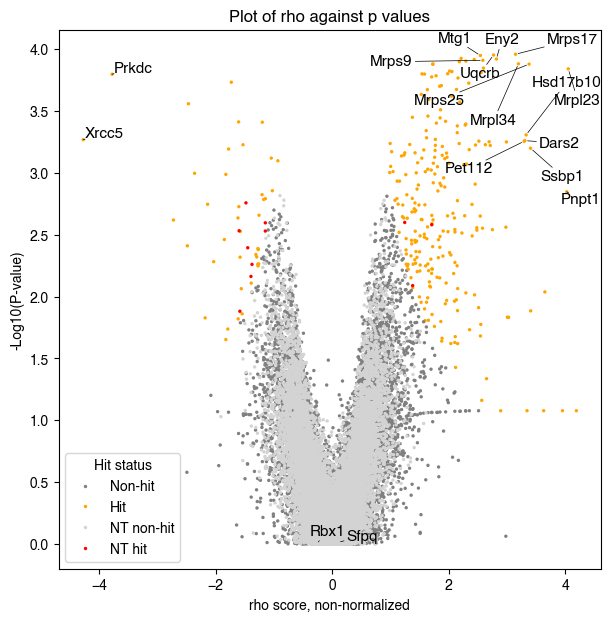

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


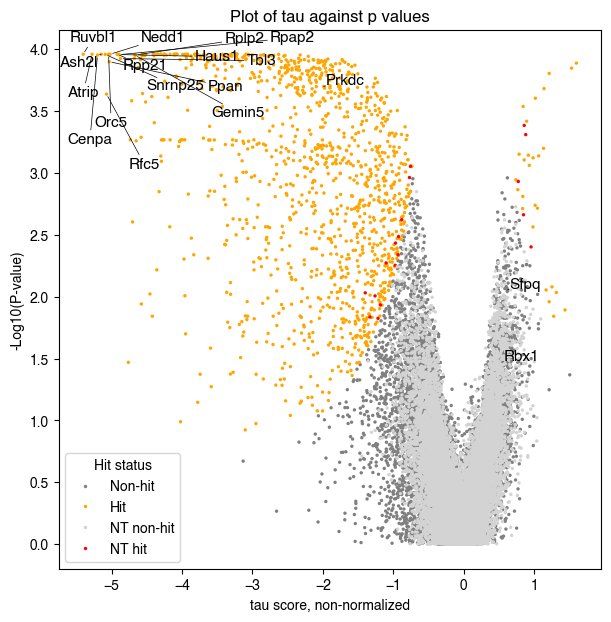

In [242]:
# Make volcano plots according to consistent format

def make_volcano_plot(df, label, threshold, plot_lims=None):
    # Determine the color based on the non-targeting/hit status
    def determine_color(row):
        if row['is_hit'] and row['target'] == 'non-targeting':
            return 'NT hit'
        elif row['is_hit'] and row['target'] != 'non-targeting':
            return 'Hit'
        elif not row['is_hit'] and row['target'] == 'non-targeting':
            return 'NT non-hit'
        else:
            return 'Non-hit'
    df['Hit status'] = df.apply(determine_color, axis = 1)
    palette = {
        "NT hit": "red",
        "Hit": "orange",
        "NT non-hit": "lightgray",
        "Non-hit": "gray"
    }

    plt.figure(figsize=(7, 7))
    # Plot the targeting data first
    sns.scatterplot(
        x='score_raw',
        y='log_pvalue',
        data=df[df["target"] != 'non-targeting'],
        hue=df['Hit status'],
        palette=palette,
        legend=False,
        s=6,
        edgecolor='none'
    )

    sns.scatterplot(
        x='score_raw',
        y='log_pvalue',
        data=df[df["target"] == 'non-targeting'],
        hue=df['Hit status'],
        palette=palette,
        legend=True,
        s=6,
        edgecolor='none'
    )
    # Threshold if need
    if plot_lims:
        plt.xlim(plot_lims[0], plot_lims[1])  # Adjust x-axis limits

    top_genes = df.nlargest(15, 'absolute_combined_score')
    genes_of_interest = df[df['target'].isin(['Rbx1', 'Sfpq', 'Prkdc'])]
    to_plot = pd.concat([top_genes, genes_of_interest]).drop_duplicates()
    texts = []
    for _, row in to_plot.iterrows():
        if row['target'] != 'non-targeting':
            text = plt.text(row['score_raw'], row['log_pvalue'], row['target'], fontsize=11)
            texts.append(text)

    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='black', lw=0.5), force_text=(1.5, 1.5), min_arrow_len=0)
    plt.xlabel(f'{label} score, non-normalized')
    plt.ylabel('-Log10(P-value)')
    plt.title(f'Plot of {label} against p values')
    plt.savefig(os.path.join(OUTPUT_DIR, f"{CELL_LINE}_{label}_hits_volcano_plot.pdf"))
    plt.show()

make_volcano_plot(gamma_scores, "gamma", gamma_threshold)
make_volcano_plot(rho_scores, "rho", rho_threshold)
make_volcano_plot(tau_scores, "tau", tau_threshold)

## Extracting plotting dataframes

In [15]:
output_dir = '../output/manuscript/invitro_screens'
cell_line = 'LN18'

In [20]:
# Get the combined scores and extract the row columns
combined_scores = pd.read_csv(f'../output/invitro_screen_outputs/{cell_line}/{cell_line}_combined_scores.csv')
df = combined_scores.filter(like='_tau')
df.columns = df.columns.str.replace('_tau', '', regex=False)

In [21]:
boundary = df[df['is_hit'] == True]['absolute_combined_score'].min()
print(f"The boundary score between hits and non-hits is: {boundary}")


The boundary score between hits and non-hits is: 4.102679280420456


In [56]:
# Determine the hit status, just like we do in the volcano plots
def determine_color(row):
    if row['is_hit'] and row['target'] == 'non-targeting':
        return 'NT hit'
    elif row['is_hit'] and row['target'] != 'non-targeting':
        return 'Hit'
    elif not row['is_hit'] and row['target'] == 'non-targeting':
        return 'NT non-hit'
    else:
        return 'Non-hit'
df['Hit status'] = df.apply(determine_color, axis = 1)
top_genes = df.nlargest(15, 'absolute_combined_score')['target'].to_list()
genes_of_interest = ['Rbx1', 'Sfpq', 'Prkdc', 'RBX1', 'SFPQ', 'PRKDC']
def determine_top_hit(row):
    return row['target'] != 'non-targeting' and (row['target'] in genes_of_interest or  row['target'] in top_genes)
df['Top 15 hits or genes of interest'] = df.apply(determine_top_hit, axis = 1)
out = df[['Hit status', 'score_raw', 'log_pvalue', 'target', 'Top 15 hits or genes of interest']]

In [57]:
out.to_csv(os.path.join(output_dir, f'Fig1A_invitro_crispr_screen_{cell_line}_volcano_plot_dataframe.csv'), index=False)